Phase 1: Setting Up and Correct Baseline Evaluation


Step 1: Setup Environment and Load Combined Data

Goal: Import necessary libraries, mount your Google Drive, and load the combined datasets (train_payload_combined.csv, val_payload_combined.csv, etc.)

In [ ]:
# === Step 1: Setup Environment and Load Combined Data ===

# Import Libraries
import pandas as pd
import numpy as np
import os
import pickle # For saving/loading scalers
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
try:
    drive.mount('/content/drive', force_remount=True) # Force remount can be helpful
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    # If mounting fails, stop here as we can't access files.

# Define project directory (IMPORTANT: Double-check this path!)
project_dir = '/content/drive/MyDrive/Project'
if not os.path.isdir(project_dir):
    print(f"ERROR: Project directory not found at: {project_dir}")
    print("Please verify the path and make sure the folder exists.")
    # Stop execution if directory doesn't exist
    raise FileNotFoundError(f"Project directory not found: {project_dir}")
else:
    print(f"Project directory found: {project_dir}")

# --- Load Combined Data ---
print("\nLoading combined CSV files...")
combined_files_loaded = True
try:
    train_payload_all = pd.read_csv(f"{project_dir}/train_payload_combined.csv")
    val_payload_all = pd.read_csv(f"{project_dir}/val_payload_combined.csv")
    test_payload_all = pd.read_csv(f"{project_dir}/test_payload_combined.csv")
    train_intention_all = pd.read_csv(f"{project_dir}/train_intention_combined.csv")
    val_intention_all = pd.read_csv(f"{project_dir}/val_intention_combined.csv")
    test_intention_all = pd.read_csv(f"{project_dir}/test_intention_combined.csv")
    print("Successfully loaded combined CSV files.")

    # Print shapes to verify
    print("\n--- Combined Data Shapes ---")
    print(f"Payload Train Shape: {train_payload_all.shape}")
    print(f"Payload Val Shape  : {val_payload_all.shape}")
    print(f"Payload Test Shape : {test_payload_all.shape}")
    print("-" * 20)
    print(f"Intention Train Shape: {train_intention_all.shape}")
    print(f"Intention Val Shape  : {val_intention_all.shape}")
    print(f"Intention Test Shape : {test_intention_all.shape}")
    print("-" * 20)

except FileNotFoundError as e:
    print(f"\nERROR loading combined file: {e}")
    print("It seems the combined CSV files (e.g., 'train_payload_combined.csv') were not found.")
    print("Please ensure you have run the concatenation code from your previous notebook")
    print("(cell ID: QjZtsPbly2r_) and saved these files in your Project directory.")
    combined_files_loaded = False
except Exception as e:
    print(f"\nAn unexpected error occurred while loading files: {e}")
    combined_files_loaded = False

# We need the data loaded to proceed.
if not combined_files_loaded:
     print("\nStopping execution because combined data could not be loaded.")
     # You might want to manually stop the notebook here or handle the error
     # by re-running the concatenation if needed.
     assert combined_files_loaded, "Combined data files are required to continue."

Mounted at /content/drive
Google Drive mounted successfully.
Project directory found: /content/drive/MyDrive/Project

Loading combined CSV files...
Successfully loaded combined CSV files.

--- Combined Data Shapes ---
Payload Train Shape: (907987, 31)
Payload Val Shape  : (147779, 31)
Payload Test Shape : (331306, 31)
--------------------
Intention Train Shape: (1146724, 31)
Intention Val Shape  : (52742, 31)
Intention Test Shape : (191517, 31)
--------------------


Step 2: Windowing, Scaling, Label Mapping, and Saving Scalers

Goal: Define the windowing function, apply it to create sequence data, correctly scale the features using scalers fitted only on the training data, save these scalers for later use, and map the target labels to integers [0, 1, 2, 3].

In [ ]:
# === Step 2: Windowing, Scaling, Label Mapping, and Saving Scalers ===

# Windowing function (same as before)
def create_windows(data, window_size=100, stride=50):
    # Expects data as a pandas DataFrame
    X, y = [], []
    num_features = data.shape[1] - 1 # All columns except the last one ('target')
    feature_cols = data.columns[:num_features]
    target_col = data.columns[-1]

    print(f"Creating windows for data with shape {data.shape}...")
    for i in range(0, len(data) - window_size + 1, stride):
        window = data.iloc[i:i+window_size][feature_cols].values
        label = data.iloc[i+window_size-1][target_col]
        X.append(window)
        y.append(label)
    X_np = np.array(X)
    y_np = np.array(y)
    print(f" -> Windowed data shape: X={X_np.shape}, y={y_np.shape}")
    return X_np, y_np

# --- Payload Data Preprocessing ---
print("\nProcessing Payload Data...")
X_train_payload, y_train_payload = create_windows(train_payload_all)
X_val_payload, y_val_payload = create_windows(val_payload_all)
X_test_payload, y_test_payload = create_windows(test_payload_all)

# Reshape for scaling (Flatten timesteps and samples)
num_features_payload = X_train_payload.shape[-1]
X_train_payload_reshaped = X_train_payload.reshape(-1, num_features_payload)
X_val_payload_reshaped = X_val_payload.reshape(-1, num_features_payload)
X_test_payload_reshaped = X_test_payload.reshape(-1, num_features_payload)
print(f"Payload Train data reshaped for scaling: {X_train_payload_reshaped.shape}")

# Fit scaler ONLY on training data
print("Fitting Payload Scaler...")
scaler_payload = StandardScaler()
scaler_payload.fit(X_train_payload_reshaped)
print("Payload Scaler fitted.")

# Save the payload scaler
scaler_payload_path = os.path.join(project_dir, 'scaler_payload_combined.pkl')
try:
    with open(scaler_payload_path, 'wb') as f:
        pickle.dump(scaler_payload, f)
    print(f"Payload scaler saved successfully to: {scaler_payload_path}")
except Exception as e:
    print(f"ERROR saving payload scaler: {e}")

# Transform all sets using the FITTED scaler
print("Transforming Payload data...")
X_train_payload_scaled_reshaped = scaler_payload.transform(X_train_payload_reshaped)
X_val_payload_scaled_reshaped = scaler_payload.transform(X_val_payload_reshaped)
X_test_payload_scaled_reshaped = scaler_payload.transform(X_test_payload_reshaped)

# Reshape back to (samples, timesteps, features)
X_train_payload = X_train_payload_scaled_reshaped.reshape(X_train_payload.shape)
X_val_payload = X_val_payload_scaled_reshaped.reshape(X_val_payload.shape)
X_test_payload = X_test_payload_scaled_reshaped.reshape(X_test_payload.shape)
print("Payload data scaling complete and reshaped back.")
print(f"Final Payload shapes: X_train={X_train_payload.shape}, X_val={X_val_payload.shape}, X_test={X_test_payload.shape}")


# --- Intention Data Preprocessing ---
print("\nProcessing Intention Data...")
X_train_intention, y_train_intention = create_windows(train_intention_all)
X_val_intention, y_val_intention = create_windows(val_intention_all)
X_test_intention, y_test_intention = create_windows(test_intention_all)

# Reshape for scaling
num_features_intention = X_train_intention.shape[-1]
X_train_intention_reshaped = X_train_intention.reshape(-1, num_features_intention)
X_val_intention_reshaped = X_val_intention.reshape(-1, num_features_intention)
X_test_intention_reshaped = X_test_intention.reshape(-1, num_features_intention)
print(f"Intention Train data reshaped for scaling: {X_train_intention_reshaped.shape}")

# Fit scaler ONLY on training data
print("Fitting Intention Scaler...")
scaler_intention = StandardScaler()
scaler_intention.fit(X_train_intention_reshaped)
print("Intention Scaler fitted.")

# Save the intention scaler
scaler_intention_path = os.path.join(project_dir, 'scaler_intention_combined.pkl')
try:
    with open(scaler_intention_path, 'wb') as f:
        pickle.dump(scaler_intention, f)
    print(f"Intention scaler saved successfully to: {scaler_intention_path}")
except Exception as e:
    print(f"ERROR saving intention scaler: {e}")

# Transform all sets
print("Transforming Intention data...")
X_train_intention_scaled_reshaped = scaler_intention.transform(X_train_intention_reshaped)
X_val_intention_scaled_reshaped = scaler_intention.transform(X_val_intention_reshaped)
X_test_intention_scaled_reshaped = scaler_intention.transform(X_test_intention_reshaped)

# Reshape back
X_train_intention = X_train_intention_scaled_reshaped.reshape(X_train_intention.shape)
X_val_intention = X_val_intention_scaled_reshaped.reshape(X_val_intention.shape)
X_test_intention = X_test_intention_scaled_reshaped.reshape(X_test_intention.shape)
print("Intention data scaling complete and reshaped back.")
print(f"Final Intention shapes: X_train={X_train_intention.shape}, X_val={X_val_intention.shape}, X_test={X_test_intention.shape}")

# --- Prepare Labels (Map to 0, 1, 2, 3) ---
print("\nMapping labels...")
payload_label_map = {0.0: 0, 5.0: 1, 10.0: 2, 15.0: 3}
# Assuming 0=Still, 1=Move1(Walking?), 2=Move2(Lifting?), 3=Move3(Lowering?) - ADJUST if needed
intention_label_map = {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3}

# Use np.vectorize for robust mapping (handles potential NaNs or unexpected values better)
vectorized_payload_map = np.vectorize(payload_label_map.get)
vectorized_intention_map = np.vectorize(intention_label_map.get)

y_train_payload_mapped = vectorized_payload_map(y_train_payload)
y_val_payload_mapped = vectorized_payload_map(y_val_payload)
y_test_payload_mapped = vectorized_payload_map(y_test_payload)

y_train_intention_mapped = vectorized_intention_map(y_train_intention)
y_val_intention_mapped = vectorized_intention_map(y_val_intention)
y_test_intention_mapped = vectorized_intention_map(y_test_intention)

# Check for any None values after mapping (indicates labels not in map)
if None in y_train_payload_mapped or None in y_val_payload_mapped or None in y_test_payload_mapped:
    print("ERROR: Found unmapped payload labels! Original unique labels:", np.unique(y_test_payload))
if None in y_train_intention_mapped or None in y_val_intention_mapped or None in y_test_intention_mapped:
    print("ERROR: Found unmapped intention labels! Original unique labels:", np.unique(y_test_intention))

print("Labels mapped.")
print("\n--- Final Mapped Label Verification ---")
print(f"Unique Payload Labels (Train): {np.unique(y_train_payload_mapped)}")
print(f"Unique Payload Labels (Val)  : {np.unique(y_val_payload_mapped)}")
print(f"Unique Payload Labels (Test) : {np.unique(y_test_payload_mapped)}")
print(f"Payload Test Label Counts    : {np.bincount(y_test_payload_mapped)}")
print("-" * 20)
print(f"Unique Intention Labels (Train): {np.unique(y_train_intention_mapped)}")
print(f"Unique Intention Labels (Val)  : {np.unique(y_val_intention_mapped)}")
print(f"Unique Intention Labels (Test) : {np.unique(y_test_intention_mapped)}")
print(f"Intention Test Label Counts    : {np.bincount(y_test_intention_mapped)}")
print("-" * 20)

# Optional: Check a small sample of scaled data
print("\nSample of scaled X_train_payload (first window, first timestep):")
print(X_train_payload[0, 0, :5]) # Print first 5 features of first timestep/window
print("\nSample of scaled X_train_intention (first window, first timestep):")
print(X_train_intention[0, 0, :5]) # Print first 5 features of first timestep/window


Processing Payload Data...
Creating windows for data with shape (907987, 31)...
 -> Windowed data shape: X=(18158, 100, 30), y=(18158,)
Creating windows for data with shape (147779, 31)...
 -> Windowed data shape: X=(2954, 100, 30), y=(2954,)
Creating windows for data with shape (331306, 31)...
 -> Windowed data shape: X=(6625, 100, 30), y=(6625,)
Payload Train data reshaped for scaling: (1815800, 30)
Fitting Payload Scaler...
Payload Scaler fitted.
Payload scaler saved successfully to: /content/drive/MyDrive/Project/scaler_payload_combined.pkl
Transforming Payload data...
Payload data scaling complete and reshaped back.
Final Payload shapes: X_train=(18158, 100, 30), X_val=(2954, 100, 30), X_test=(6625, 100, 30)

Processing Intention Data...
Creating windows for data with shape (1146724, 31)...
 -> Windowed data shape: X=(22933, 100, 30), y=(22933,)
Creating windows for data with shape (52742, 31)...
 -> Windowed data shape: X=(1053, 100, 30), y=(1053,)
Creating windows for data with

Step 3: Load Saved Models and Evaluate Baseline Performance

Goal: Load the .h5 models that were previously trained on the combined user data (saved in cell IGNUVaQty7gU of your original notebook). Evaluate these models on the correctly preprocessed combined test sets prepared in Step 2. This establishes the correct baseline performance.


Loading previously saved models trained on combined data...


Loaded payload model from: /content/drive/MyDrive/Project/payload_model.h5


Loaded intention model from: /content/drive/MyDrive/Project/intention_model.h5

Evaluating Baseline Payload Model on Combined Test Set...
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step

Baseline Payload Model Classification Report (Combined Test Data):
              precision    recall  f1-score   support

        0 kg       0.99      0.95      0.97      5404
        5 kg       0.66      0.80      0.72       373
       10 kg       0.62      0.80      0.70       411
       15 kg       0.76      0.81      0.78       437

    accuracy                           0.92      6625
   macro avg       0.76      0.84      0.79      6625
weighted avg       0.93      0.92      0.93      6625

Baseline payload report saved to: /content/drive/MyDrive/Project/combined_payload_baseline_report.txt


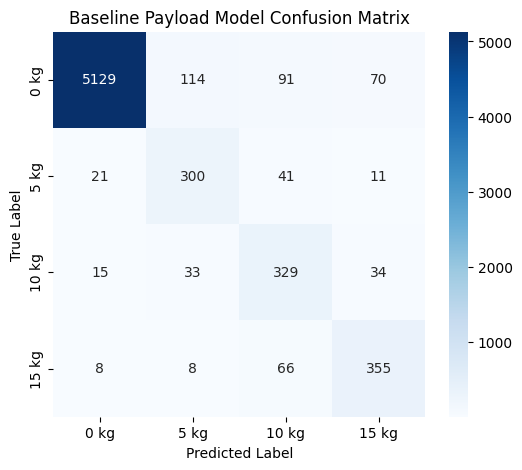


Evaluating Baseline Intention Model on Combined Test Set...
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step

Baseline Intention Model Classification Report (Combined Test Data):
              precision    recall  f1-score   support

       Still       0.56      0.70      0.62      1758
       Move1       0.33      0.09      0.14      1326
       Move2       0.20      0.37      0.26       365
       Move3       0.20      0.33      0.25       380

    accuracy                           0.42      3829
   macro avg       0.32      0.37      0.32      3829
weighted avg       0.41      0.42      0.38      3829

Baseline intention report saved to: /content/drive/MyDrive/Project/combined_intention_baseline_report.txt


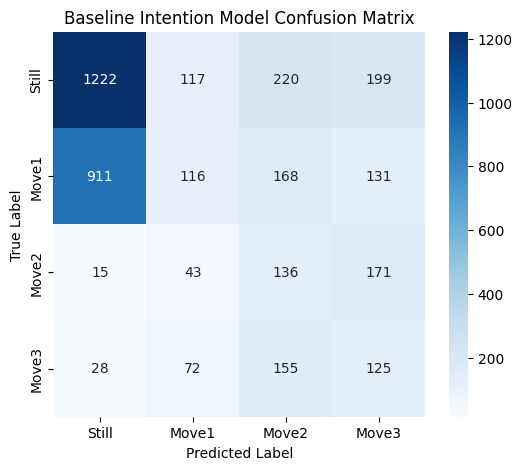

In [ ]:
# === Step 3: Load Saved Models and Evaluate Baseline Performance ===

# Define model paths (these should be the models trained on combined data)
payload_model_path = f"{project_dir}/payload_model.h5"
intention_model_path = f"{project_dir}/intention_model.h5"

# --- Load Models ---
print("\nLoading previously saved models trained on combined data...")
try:
    # Load payload model
    if os.path.exists(payload_model_path):
        payload_model_baseline = load_model(payload_model_path)
        print(f"Loaded payload model from: {payload_model_path}")
    else:
        print(f"ERROR: Payload model file not found at {payload_model_path}")
        payload_model_baseline = None

    # Load intention model
    if os.path.exists(intention_model_path):
        intention_model_baseline = load_model(intention_model_path)
        print(f"Loaded intention model from: {intention_model_path}")
    else:
        print(f"ERROR: Intention model file not found at {intention_model_path}")
        intention_model_baseline = None

except Exception as e:
    print(f"An error occurred during model loading: {e}")
    # Set models to None if loading failed to prevent errors later
    payload_model_baseline = None
    intention_model_baseline = None

# --- Evaluate Payload Model ---
if payload_model_baseline:
    print("\nEvaluating Baseline Payload Model on Combined Test Set...")
    try:
        y_pred_payload_probs_base = payload_model_baseline.predict(X_test_payload)
        y_pred_payload_base = np.argmax(y_pred_payload_probs_base, axis=1)
        payload_target_names = ['0 kg', '5 kg', '10 kg', '15 kg']

        print("\nBaseline Payload Model Classification Report (Combined Test Data):")
        payload_report_base = classification_report(y_test_payload_mapped, y_pred_payload_base, target_names=payload_target_names)
        print(payload_report_base)

        # Save the baseline report
        report_path = f"{project_dir}/combined_payload_baseline_report.txt"
        with open(report_path, 'w') as f:
            f.write("Baseline Payload Model Evaluation (Combined Test Data):\n")
            f.write(payload_report_base)
        print(f"Baseline payload report saved to: {report_path}")

        # Optional: Display Confusion Matrix
        cm_payload_base = confusion_matrix(y_test_payload_mapped, y_pred_payload_base)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_payload_base, annot=True, fmt='d', xticklabels=payload_target_names, yticklabels=payload_target_names, cmap='Blues')
        plt.title('Baseline Payload Model Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    except Exception as e:
        print(f"Error during payload model evaluation: {e}")
else:
    print("\nSkipping baseline payload model evaluation because the model was not loaded.")


# --- Evaluate Intention Model ---
if intention_model_baseline:
    print("\nEvaluating Baseline Intention Model on Combined Test Set...")
    try:
        y_pred_intention_probs_base = intention_model_baseline.predict(X_test_intention)
        y_pred_intention_base = np.argmax(y_pred_intention_probs_base, axis=1)
        # Adjust target names if you know what Move1/2/3 are
        intention_target_names = ['Still', 'Move1', 'Move2', 'Move3']

        print("\nBaseline Intention Model Classification Report (Combined Test Data):")
        intention_report_base = classification_report(y_test_intention_mapped, y_pred_intention_base, target_names=intention_target_names)
        print(intention_report_base)

        # Save the baseline report
        report_path = f"{project_dir}/combined_intention_baseline_report.txt"
        with open(report_path, 'w') as f:
            f.write("Baseline Intention Model Evaluation (Combined Test Data):\n")
            f.write(intention_report_base)
        print(f"Baseline intention report saved to: {report_path}")

        # Optional: Display Confusion Matrix
        cm_intention_base = confusion_matrix(y_test_intention_mapped, y_pred_intention_base)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_intention_base, annot=True, fmt='d', xticklabels=intention_target_names, yticklabels=intention_target_names, cmap='Blues')
        plt.title('Baseline Intention Model Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    except Exception as e:
        print(f"Error during intention model evaluation: {e}")
else:
    print("\nSkipping baseline intention model evaluation because the model was not loaded.")

Phase 2: Improving the Models

Step 4: Improve Intention Model (using SMOTE & BiLSTM/CNN-BiLSTM)

imblearn version: 0.13.0

--- Training Improved Intention Model ---
Applying SMOTE to Intention Training Data...
Original training shape: (22933, 100, 30)
Original label distribution: [15339  2694  2465  2435]
Using k_neighbors=5 for SMOTE.
Shape after SMOTE: (61356, 100, 30)
Resampled Label Distribution: [15339 15339 15339 15339]
SMOTE applied successfully.
Created CNN-BiLSTM Model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 64)        │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 25, 64)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,980 (167.89 KB)

 Trainable params: 42,980 (167.89 KB)

 Non-trainable params: 0 (0.00 B)


Starting Training for Improved Intention Model...
Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 75s 69ms/step - accuracy: 0.8398 - loss: 0.4759 - val_accuracy: 0.8851 - val_loss: 0.3733
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 66s 68ms/step - accuracy: 0.9507 - loss: 0.1677 - val_accuracy: 0.8870 - val_loss: 0.3854
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 64s 66ms/step - accuracy: 0.9563 - loss: 0.1402 - val_accuracy: 0.8965 - val_loss: 0.3524
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.9593 - loss: 0.1308 - val_accuracy: 0.8965 - val_loss: 0.3655
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.9618 - loss: 0.1184 - val_accuracy: 0.8955 - val_loss: 0.4004
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9635 - loss: 0.1137 - val_accuracy: 0.8936 - val_loss: 0.4062
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 76s 79ms/step - accuracy: 0.9645 - loss: 0.1104 - val_accuracy: 0.8594 - val_loss: 0.4395
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━

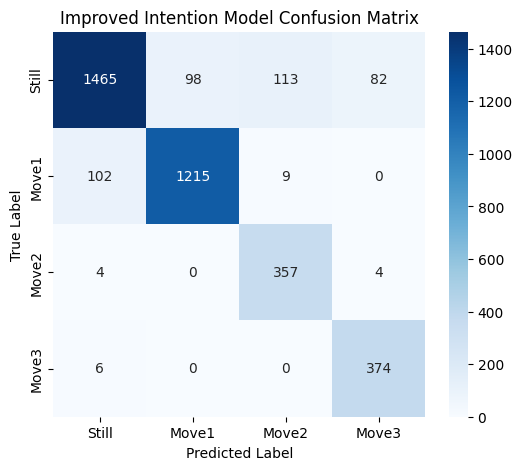

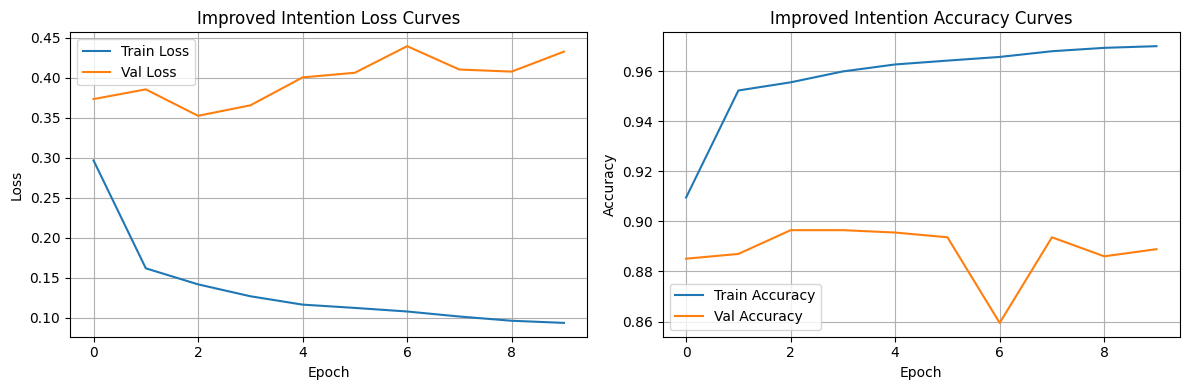

In [ ]:
# === Step 4: Improve Intention Model (SMOTE & BiLSTM/CNN-BiLSTM) ===

# Ensure imblearn is installed (might be needed if runtime restarted)
try:
    import imblearn
    print(f"imblearn version: {imblearn.__version__}")
except ImportError:
    print("Installing imblearn...")
    !pip install -q imblearn
    import imblearn
    print(f"imblearn version: {imblearn.__version__}")

from imblearn.over_sampling import SMOTE

print("\n--- Training Improved Intention Model ---")

# --- Option: Apply SMOTE to the Training Data ---
# Note: SMOTE can be memory-intensive on large datasets.
# If this step fails due to memory, we might need to only use class weights.
print("Applying SMOTE to Intention Training Data...")
# Reshape for SMOTE: (samples, timesteps * features)
X_train_intention_reshaped_smote = X_train_intention.reshape(X_train_intention.shape[0], -1)
print(f"Original training shape: {X_train_intention.shape}")
print(f"Original label distribution: {np.bincount(y_train_intention_mapped)}")

# Determine k_neighbors based on the smallest class size BEFORE SMOTE
min_class_size = np.min(np.bincount(y_train_intention_mapped))
k_neighbors_smote = min(5, min_class_size - 1) # Use k=5 or less if classes are very small
if k_neighbors_smote < 1:
     k_neighbors_smote = 1 # Minimum k_neighbors is 1
print(f"Using k_neighbors={k_neighbors_smote} for SMOTE.")

smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
try:
    X_train_intent_res_sm, y_train_intent_res_sm = smote.fit_resample(X_train_intention_reshaped_smote, y_train_intention_mapped)
    # Reshape back: (samples, timesteps, features)
    X_train_intent_final = X_train_intent_res_sm.reshape(-1, X_train_intention.shape[1], X_train_intention.shape[2])
    y_train_intent_final = y_train_intent_res_sm
    print(f"Shape after SMOTE: {X_train_intent_final.shape}")
    print(f"Resampled Label Distribution: {np.bincount(y_train_intent_final)}")
    use_class_weights = None # Don't use strong class weighting when using SMOTE
    print("SMOTE applied successfully.")
except ValueError as e:
     print(f"SMOTE failed: {e}. This might be due to small class sizes.")
     print("Proceeding with original data and class weights instead.")
     X_train_intent_final = X_train_intention
     y_train_intent_final = y_train_intention_mapped
     # Calculate class weights if SMOTE fails
     intention_classes = np.unique(y_train_intention_mapped)
     intention_weights = compute_class_weight('balanced', classes=intention_classes, y=y_train_intention_mapped)
     use_class_weights = dict(zip(intention_classes, intention_weights))
     print("Using Calculated Class Weights:", use_class_weights)
except Exception as e:
     print(f"An unexpected error occurred during SMOTE: {e}")
     print("Stopping execution.")
     raise e # Stop if it's an unknown error

# --- Define Model Architecture Functions ---
def create_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3), # Increased dropout slightly
        Bidirectional(LSTM(32)),
        Dropout(0.3), # Increased dropout slightly
        Dense(num_classes, activation='softmax')
    ])
    print("Created BiLSTM Model")
    return model

def create_cnn_bilstm_model(input_shape, num_classes):
     model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'), # Wider kernel?
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        # Flatten might be too aggressive here, let BiLSTM handle sequence
        Bidirectional(LSTM(32, return_sequences=True)), # Maybe keep more units
        Dropout(0.4), # Increase dropout
        Bidirectional(LSTM(16)),
        Dropout(0.4), # Increase dropout
        Dense(num_classes, activation='softmax')
    ])
     print("Created CNN-BiLSTM Model")
     return model

# --- Create and Compile the Improved Model ---
input_shape_intention = (X_train_intent_final.shape[1], X_train_intent_final.shape[2])

# Choose Architecture: CNN-BiLSTM often performs well on sensor time series
intention_model_improved = create_cnn_bilstm_model(input_shape_intention, num_classes=4)
# OR uncomment below to try BiLSTM only
# intention_model_improved = create_bilstm_model(input_shape_intention, num_classes=4)

# Compile with potentially slightly lower learning rate
intention_model_improved.compile(
    optimizer=Adam(learning_rate=0.0005), # Start with 0.0005 or 0.001
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
intention_model_improved.summary()

# --- Training ---
print("\nStarting Training for Improved Intention Model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1) # Slightly more patience

intention_history = intention_model_improved.fit(
    X_train_intent_final, y_train_intent_final,        # Use SMOTE'd data if created
    validation_data=(X_val_intention, y_val_intention_mapped),
    epochs=50,                                         # Increase epochs, let early stopping decide
    batch_size=64,                                     # Try larger batch size
    class_weight=use_class_weights,                    # Pass weights dict or None (if SMOTE used)
    callbacks=[early_stopping],
    verbose=1
)

# --- Save the Trained Model ---
# Use the .keras format (recommended)
improved_intention_model_path = f"{project_dir}/intention_model_improved_combined.keras"
try:
    intention_model_improved.save(improved_intention_model_path)
    print(f"✅ Improved Intention Model saved to: {improved_intention_model_path}")
except Exception as e:
    print(f"ERROR saving improved intention model: {e}")

# --- Evaluate the Improved Model ---
print("\nEvaluating Improved Intention Model on Combined Test Set...")
try:
    y_pred_intention_probs_imp = intention_model_improved.predict(X_test_intention)
    y_pred_intention_imp = np.argmax(y_pred_intention_probs_imp, axis=1)
    # Adjust target names if necessary
    intention_target_names = ['Still', 'Move1', 'Move2', 'Move3']

    print("\nImproved Intention Model Classification Report (Combined Test Data):")
    intention_report_imp = classification_report(y_test_intention_mapped, y_pred_intention_imp, target_names=intention_target_names)
    print(intention_report_imp)

    # Save the improved report
    report_path_imp = f"{project_dir}/combined_intention_improved_report.txt"
    with open(report_path_imp, 'w') as f:
        f.write("Improved Intention Model Evaluation (Combined Test Data):\n")
        f.write(intention_report_imp)
    print(f"Improved intention report saved to: {report_path_imp}")

    # Display Confusion Matrix
    cm_intention_imp = confusion_matrix(y_test_intention_mapped, y_pred_intention_imp)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_intention_imp, annot=True, fmt='d', xticklabels=intention_target_names, yticklabels=intention_target_names, cmap='Blues')
    plt.title('Improved Intention Model Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(intention_history.history['loss'], label='Train Loss')
    plt.plot(intention_history.history['val_loss'], label='Val Loss')
    plt.title('Improved Intention Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(intention_history.history['accuracy'], label='Train Accuracy')
    plt.plot(intention_history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Improved Intention Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during improved intention model evaluation: {e}")

Step 5: Improve Payload Model

imblearn version: 0.13.0

--- Training Improved Payload Model ---
Applying SMOTE to Payload Training Data...
Original training shape: (18158, 100, 30)
Original label distribution: [13960  1262  1387  1549]
Using k_neighbors=5 for SMOTE.
Shape after SMOTE: (55840, 100, 30)
Resampled Label Distribution: [13960 13960 13960 13960]
SMOTE applied successfully for payload.
Created BiLSTM Model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │        48,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,116 (352.02 KB)

 Trainable params: 90,116 (352.02 KB)

 Non-trainable params: 0 (0.00 B)


Starting Training for Improved Payload Model...
Epoch 1/50
873/873 ━━━━━━━━━━━━━━━━━━━━ 220s 244ms/step - accuracy: 0.6910 - loss: 0.7444 - val_accuracy: 0.8582 - val_loss: 0.4256
Epoch 2/50
873/873 ━━━━━━━━━━━━━━━━━━━━ 259s 241ms/step - accuracy: 0.9093 - loss: 0.2667 - val_accuracy: 0.8710 - val_loss: 0.4253
Epoch 3/50
873/873 ━━━━━━━━━━━━━━━━━━━━ 209s 240ms/step - accuracy: 0.9311 - loss: 0.2014 - val_accuracy: 0.8798 - val_loss: 0.4130
Epoch 4/50
873/873 ━━━━━━━━━━━━━━━━━━━━ 262s 240ms/step - accuracy: 0.9513 - loss: 0.1505 - val_accuracy: 0.8903 - val_loss: 0.3947
Epoch 5/50
873/873 ━━━━━━━━━━━━━━━━━━━━ 210s 240ms/step - accuracy: 0.9594 - loss: 0.1244 - val_accuracy: 0.8896 - val_loss: 0.3695
Epoch 6/50
873/873 ━━━━━━━━━━━━━━━━━━━━ 212s 243ms/step - accuracy: 0.9671 - loss: 0.0993 - val_accuracy: 0.8923 - val_loss: 0.3865
Epoch 7/50
873/873 ━━━━━━━━━━━━━━━━━━━━ 262s 243ms/step - accuracy: 0.9632 - loss: 0.1082 - val_accuracy: 0.8978 - val_loss: 0.3845
Epoch 8/50
873/873 ━━━━━━━━

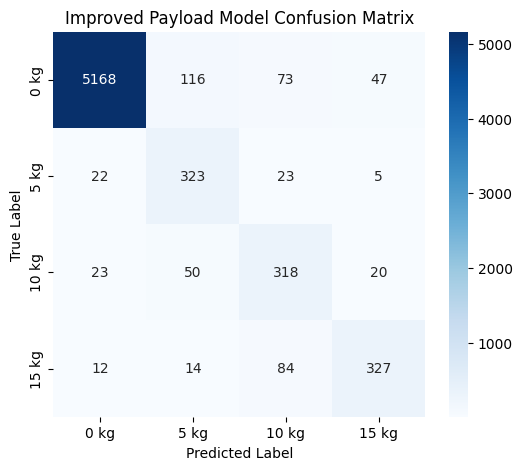

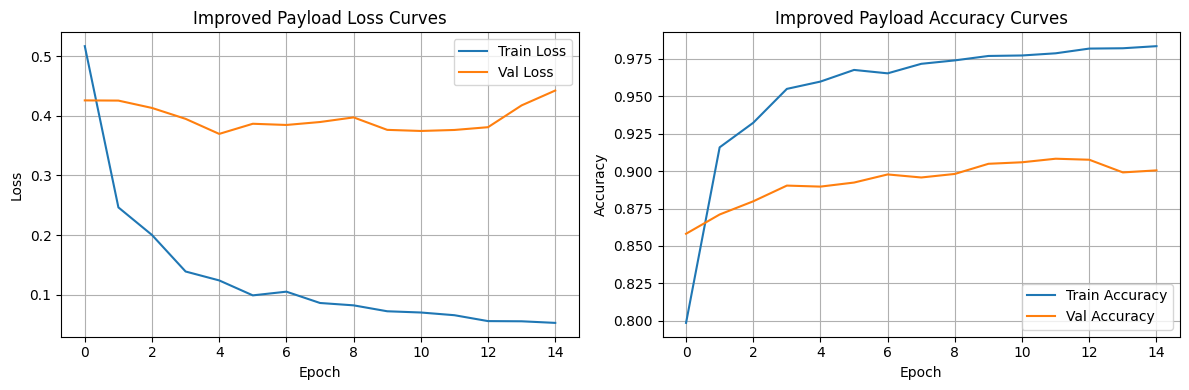

In [ ]:
# === Step 5: Improve Payload Model ===

# Ensure imblearn is installed
try:
    import imblearn
    print(f"imblearn version: {imblearn.__version__}")
except ImportError:
    print("Installing imblearn...")
    !pip install -q imblearn
    import imblearn
    print(f"imblearn version: {imblearn.__version__}")

from imblearn.over_sampling import SMOTE

print("\n--- Training Improved Payload Model ---")

# --- Option 1: Use SMOTE (often good if minority classes are distinct) ---
print("Applying SMOTE to Payload Training Data...")
X_train_payload_reshaped_smote = X_train_payload.reshape(X_train_payload.shape[0], -1)
print(f"Original training shape: {X_train_payload.shape}")
print(f"Original label distribution: {np.bincount(y_train_payload_mapped)}")

min_class_size_payload = np.min(np.bincount(y_train_payload_mapped))
k_neighbors_payload_smote = min(5, min_class_size_payload - 1)
if k_neighbors_payload_smote < 1: k_neighbors_payload_smote = 1
print(f"Using k_neighbors={k_neighbors_payload_smote} for SMOTE.")

smote_payload = SMOTE(random_state=42, k_neighbors=k_neighbors_payload_smote)
try:
    X_train_payload_res_sm, y_train_payload_res_sm = smote_payload.fit_resample(X_train_payload_reshaped_smote, y_train_payload_mapped)
    X_train_payload_final = X_train_payload_res_sm.reshape(-1, X_train_payload.shape[1], X_train_payload.shape[2])
    y_train_payload_final = y_train_payload_res_sm
    print(f"Shape after SMOTE: {X_train_payload_final.shape}")
    print(f"Resampled Label Distribution: {np.bincount(y_train_payload_final)}")
    use_payload_class_weights = None
    print("SMOTE applied successfully for payload.")
except ValueError as e:
     print(f"SMOTE failed for payload: {e}. Falling back to class weights.")
     X_train_payload_final = X_train_payload
     y_train_payload_final = y_train_payload_mapped
     # --- Option 2: Use Class Weights (if SMOTE fails or as alternative) ---
     payload_classes = np.unique(y_train_payload_mapped)
     payload_weights = compute_class_weight('balanced', classes=payload_classes, y=y_train_payload_mapped)
     use_payload_class_weights = dict(zip(payload_classes, payload_weights))
     # Optional: Slightly boost minority weights more if needed
     # use_payload_class_weights[1] *= 1.1 # 5kg
     # use_payload_class_weights[2] *= 1.1 # 10kg
     # use_payload_class_weights[3] *= 1.1 # 15kg
     print("Using Calculated Class Weights for payload:", use_payload_class_weights)
except Exception as e:
     print(f"An unexpected error occurred during payload SMOTE: {e}")
     raise e

# --- Create and Compile the Improved Model ---
input_shape_payload = (X_train_payload_final.shape[1], X_train_payload_final.shape[2])

# Try BiLSTM first for payload, as baseline was already good
payload_model_improved = create_bilstm_model(input_shape_payload, num_classes=4)
# OR try CNN-BiLSTM
# payload_model_improved = create_cnn_bilstm_model(input_shape_payload, num_classes=4)

# Compile
payload_model_improved.compile(
    optimizer=Adam(learning_rate=0.0005), # Experiment with LR if needed
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
payload_model_improved.summary()

# --- Training ---
print("\nStarting Training for Improved Payload Model...")
# Use the same early stopping callback instance
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # Maybe slightly more patience for payload

payload_history = payload_model_improved.fit(
    X_train_payload_final, y_train_payload_final,      # Use SMOTE'd or original data
    validation_data=(X_val_payload, y_val_payload_mapped),
    epochs=50,
    batch_size=64,
    class_weight=use_payload_class_weights,            # Pass weights dict or None
    callbacks=[early_stopping],
    verbose=1
)

# --- Save the Trained Model ---
improved_payload_model_path = f"{project_dir}/payload_model_improved_combined.keras"
try:
    payload_model_improved.save(improved_payload_model_path)
    print(f"✅ Improved Payload Model saved to: {improved_payload_model_path}")
except Exception as e:
    print(f"ERROR saving improved payload model: {e}")


# --- Evaluate the Improved Model ---
print("\nEvaluating Improved Payload Model on Combined Test Set...")
try:
    y_pred_payload_probs_imp = payload_model_improved.predict(X_test_payload)
    y_pred_payload_imp = np.argmax(y_pred_payload_probs_imp, axis=1)
    payload_target_names = ['0 kg', '5 kg', '10 kg', '15 kg']

    print("\nImproved Payload Model Classification Report (Combined Test Data):")
    payload_report_imp = classification_report(y_test_payload_mapped, y_pred_payload_imp, target_names=payload_target_names)
    print(payload_report_imp)

    # Save the improved report
    report_path_imp = f"{project_dir}/combined_payload_improved_report.txt"
    with open(report_path_imp, 'w') as f:
        f.write("Improved Payload Model Evaluation (Combined Test Data):\n")
        f.write(payload_report_imp)
    print(f"Improved payload report saved to: {report_path_imp}")

    # Display Confusion Matrix
    cm_payload_imp = confusion_matrix(y_test_payload_mapped, y_pred_payload_imp)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_payload_imp, annot=True, fmt='d', xticklabels=payload_target_names, yticklabels=payload_target_names, cmap='Blues')
    plt.title('Improved Payload Model Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(payload_history.history['loss'], label='Train Loss')
    plt.plot(payload_history.history['val_loss'], label='Val Loss')
    plt.title('Improved Payload Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(payload_history.history['accuracy'], label='Train Accuracy')
    plt.plot(payload_history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Improved Payload Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during improved payload model evaluation: {e}")

Step 6: Create Gradio Demo App

In [ ]:
# === Step 6: Create Gradio Demo App (Alternative - Select File & Row) ===

# Ensure gradio is installed
try:
    import gradio as gr
    print(f"Gradio version: {gr.__version__}")
except ImportError:
    print("Installing Gradio...")
    !pip install -q gradio
    import gradio as gr
    print(f"Gradio version: {gr.__version__}")

import pandas as pd
import numpy as np
import os
import pickle
from tensorflow.keras.models import load_model

# --- Configuration ---
project_dir = '/content/drive/MyDrive/Project'
payload_model_path = f"{project_dir}/payload_model_improved_combined.keras" # Use the improved model
intention_model_path = f"{project_dir}/intention_model_improved_combined.keras" # Use the improved model
scaler_payload_path = f"{project_dir}/scaler_payload_combined.pkl"
scaler_intention_path = f"{project_dir}/scaler_intention_combined.pkl"

window_size = 100
num_features = 30 # Should match your data

# --- Load Models and Scalers (Load once) ---
print("Loading models and scalers...")
models_loaded = True
try:
    payload_model = load_model(payload_model_path)
    intention_model = load_model(intention_model_path)
    with open(scaler_payload_path, 'rb') as f:
        scaler_payload = pickle.load(f)
    with open(scaler_intention_path, 'rb') as f:
        scaler_intention = pickle.load(f)
    print("Models and scalers loaded successfully.")
except Exception as e:
    print(f"ERROR loading models or scalers: {e}")
    models_loaded = False

# --- List available test files ---
available_test_files = [
    f for f in os.listdir(project_dir)
    if f.startswith("test_") and f.endswith("_combined.csv")
]
if not available_test_files:
    print("WARNING: No combined test files found (e.g., test_payload_combined.csv). Demo might not work fully.")
    # Optionally add individual user test files if needed as fallback
    # available_test_files.extend([f for f in os.listdir(project_dir) if f.startswith("U001_test_") and f.endswith(".csv")])


# --- Define Prediction Function ---
def predict_from_file_and_row(filename, start_row):
    """
    Loads a CSV file from project_dir, extracts a window, preprocesses, and predicts.
    """
    if not models_loaded:
        return "Error: Models/Scalers not loaded.", {}, "Error: Models/Scalers not loaded.", {}

    if not filename:
         return "Please select a file.", {}, "Please select a file.", {}

    filepath = os.path.join(project_dir, filename)
    if not os.path.exists(filepath):
         return f"Error: File not found: {filename}", {}, f"Error: File not found: {filename}", {}

    try:
        start_row = int(start_row) # Ensure start_row is an integer
        df = pd.read_csv(filepath)

        # Validate start_row
        if start_row < 0 or start_row > len(df) - window_size:
             return (f"Error: Start row must be between 0 and {len(df) - window_size}.", {},
                     f"Error: Start row must be between 0 and {len(df) - window_size}.", {})

        # Extract features (all columns except 'target')
        if 'target' not in df.columns:
             return "Error: 'target' column not found in CSV.", {}, "Error: 'target' column not found in CSV.", {}
        feature_columns = df.columns.drop('target')
        if len(feature_columns) != num_features:
             return (f"Error: Expected {num_features} features, found {len(feature_columns)}.", {},
                     f"Error: Expected {num_features} features, found {len(feature_columns)}.", {})

        # Get the 100-row segment of FEATURES
        segment_data = df.iloc[start_row : start_row + window_size][feature_columns].values

        # Scale the data using the correct pre-fitted scaler
        # Decide which scaler based on filename (simple check)
        if "payload" in filename.lower():
            scaled_segment = scaler_payload.transform(segment_data)
            window_data = scaled_segment.reshape(1, window_size, num_features)
            # Predict Payload
            pred_probs = payload_model.predict(window_data)[0]
            pred_class_idx = np.argmax(pred_probs)
            class_map = {0: '0 kg', 1: '5 kg', 2: '10 kg', 3: '15 kg'}
            model_type = "Payload"
        elif "intention" in filename.lower():
            scaled_segment = scaler_intention.transform(segment_data)
            window_data = scaled_segment.reshape(1, window_size, num_features)
            # Predict Intention
            pred_probs = intention_model.predict(window_data)[0]
            pred_class_idx = np.argmax(pred_probs)
            class_map = {0: 'Still', 1: 'Move1', 2: 'Move2', 3: 'Move3'}
            model_type = "Intention"
        else:
            # Default or error if filename doesn't clearly indicate type
            return "Error: Cannot determine model type from filename.", {}, "Error: Cannot determine model type from filename.", {}


        prediction_label = class_map.get(pred_class_idx, "Unknown")
        confidence = pred_probs[pred_class_idx]
        output_text = f"Prediction ({model_type}): {prediction_label} (Confidence: {confidence:.2f})"
        probabilities = {class_map.get(i, f"Class {i}"): float(prob) for i, prob in enumerate(pred_probs)}

        # Return results for the correct output fields
        if model_type == "Payload":
            return output_text, probabilities, "N/A (Select Intention File)", {}
        else: # Intention
            return "N/A (Select Payload File)", {}, output_text, probabilities


    except Exception as e:
        return f"Error processing: {e}", {}, f"Error processing: {e}", {}

# --- Create Gradio Interface ---
if models_loaded:
    print("\nLaunching Gradio Interface...")
    with gr.Blocks() as demo:
        gr.Markdown("# IMU Payload & Intention Classifier Demo")
        gr.Markdown(f"Select a combined test file and a starting row index. The demo will analyze the {window_size}-row window starting from that index.")

        with gr.Row():
            file_dropdown = gr.Dropdown(choices=available_test_files, label="Select Test File")
            row_input = gr.Number(label=f"Starting Row Index (0 to Max-{window_size})", value=0) # Use Number input

        # Use Button to trigger prediction
        predict_button = gr.Button("Predict")

        with gr.Row():
            payload_output_text = gr.Textbox(label="Payload Prediction Result", interactive=False)
            intention_output_text = gr.Textbox(label="Intention Prediction Result", interactive=False)

        with gr.Row():
            payload_output_label = gr.Label(label="Payload Probabilities", num_top_classes=4)
            intention_output_label = gr.Label(label="Intention Probabilities", num_top_classes=4)

        # Connect button click to function
        predict_button.click(predict_from_file_and_row,
                             inputs=[file_dropdown, row_input],
                             outputs=[payload_output_text, payload_output_label, intention_output_text, intention_output_label])

    # Launch in Colab
    demo.launch(debug=True)
else:
    print("Gradio interface cannot be launched because models/scalers failed to load.")

Gradio version: 5.31.0
Loading models and scalers...
Models and scalers loaded successfully.

Launching Gradio Interface...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://259dbf1b7f56e0694c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# === Save Trained INTENTION Model ===
import os
from google.colab import drive # Make sure drive is mounted if needed
import tensorflow as tf # Make sure tensorflow is imported

# Define project directory (should match what you used before)
project_dir = '/content/drive/MyDrive/Project'

# Define the path for the improved intention model
improved_intention_model_path = f"{project_dir}/intention_model_improved_combined.keras"

# Check if the model variable exists from your training step
if 'intention_model_improved' in locals():
    try:
        intention_model_improved.save(improved_intention_model_path)
        print(f"✅ Improved Intention Model saved successfully to: {improved_intention_model_path}")
    except Exception as e:
        print(f"ERROR saving improved intention model: {e}")
else:
    print("ERROR: Variable 'intention_model_improved' not found. Make sure the training cell (Step 4) finished and the model object was created.")

In [ ]:
# === Save Trained PAYLOAD Model ===
import os
from google.colab import drive # Make sure drive is mounted if needed
import tensorflow as tf # Make sure tensorflow is imported

# Define project directory (should match what you used before)
project_dir = '/content/drive/MyDrive/Project'

# Define the path for the improved payload model
improved_payload_model_path = f"{project_dir}/payload_model_improved_combined.keras"

# Check if the model variable exists from your training step
if 'payload_model_improved' in locals():
    try:
        payload_model_improved.save(improved_payload_model_path)
        print(f"✅ Improved Payload Model saved successfully to: {improved_payload_model_path}")
    except Exception as e:
        print(f"ERROR saving improved payload model: {e}")
else:
    print("ERROR: Variable 'payload_model_improved' not found. Make sure the training cell (Step 5) finished and the model object was created.")